In [1]:



from __future__ import print_function
import argparse
import os
# import h5py
import random
import time
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from DropBlock_attention import DropBlock2D


In [2]:
import spectral

In [3]:

parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=0)
parser.add_argument('--batchSize', type=int, default=100, help='input batch size')
parser.add_argument('--imageSize', type=int, default=28, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=5, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--decreasing_lr', default='120,240,420,620,800', help='decreasing strategy')
parser.add_argument('--wd', type=float, default=0.001, help='weight decay')
parser.add_argument('--clamp_lower', type=float, default=-0.01)
parser.add_argument('--clamp_upper', type=float, default=0.01)
opt = parser.parse_args(args = [])

In [4]:
opt.outf = 'model'
opt.cuda = False
print(opt)
CRITIC_ITERS = 1
try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)
cudnn.benchmark = False


if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

"""
matfn1 = 'E:/matconvnet/matconvnet/Salinas/Salinas_corrected.mat'
data1 = sio.loadmat(matfn1)
Sa = data1['salinas_corrected']
matfn2 = 'E:/matconvnet/matconvnet/Salinas/Salinas_gt.mat'
data2 = sio.loadmat(matfn2)
GroundTruth = data2['salinas_gt']

matfn3 = 'E:/matconvnet/matconvnet/Salinas/PC.mat'
data3 = sio.loadmat(matfn3)
PCData = data3['PCData']

[nRow, nColumn, nBand] = PCData.shape
"""
###PCA变换
def applyPCA(X,numComponents):
    newX=np.reshape(X,(-1,X.shape[2]))
    pca=PCA(n_components=numComponents,whiten=True)
    newX=pca.fit_transform(newX)
    newX=np.reshape(newX,(X.shape[0],X.shape[1],numComponents))
    return newX
####加padding
def padWithZeros(X,margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin,X.shape[2]))
    newX[margin:X.shape[0]+margin,margin:X.shape[1]+margin,:] = X
    return newX
def createImageCubes(X,y,windowSize=5,removeZeroLabels=True):
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
	    for c in range(margin,zeroPaddedX.shape[1]-margin):
		    patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
		    patchesData[patchIndex,:,:,:]=patch
		    patchesLabels[patchIndex]=y[r-margin,c-margin]
		    patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels-=1
    return patchesData,patchesLabels


def splitTrainTestSet(X,y,testRatio,randomState=345):
    X_train,X_test,y_train,y_test=X*(1-testRatio),X*testRatio,y*(1-testRatio),y*testRatio
    return X_train,X_test,y_train,y_test
def flip(data):

    y_4 = np.zeros_like(data)
    y_1 = y_4
    y_2 = y_4
    first = np.concatenate((y_1, y_2, y_1), axis=1)
    second = np.concatenate((y_4, data, y_4), axis=1)
    third = first
    Data = np.concatenate((first, second, third), axis=0)
    return Data



#num_class = 16
data_path = os.path.join(os.getcwd(),'data')
# matfn1 = 'MAE/data/Indian_pines_corrected.mat'
# data1 = sio.loadmat(matfn1)
# X = data1['indian_pines_corrected']
X = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
y = labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
# matfn2='MAE/data/Indian_pines_gt.mat'
# data2=sio.loadmat(matfn2)
# y = data2['indian_pines_gt']
test_ratio=0.90
patch_size=25
pca_components=3
print('Hyperspectral data shape:',X.shape)
print('Label shape:',y.shape)
X_pca=applyPCA(X,numComponents=pca_components)
print('Data shape after PCA :',X_pca.shape)
[nRow, nColumn, nBand] = X_pca.shape
pcdata = flip(X_pca)
groundtruth = flip(y)

num_class = int(np.max(y))


HalfWidth = 32
Wid = 2 * HalfWidth
G = groundtruth[nRow - HalfWidth:2 * nRow + HalfWidth, nColumn - HalfWidth:2 * nColumn + HalfWidth]
data = pcdata[nRow - HalfWidth:2 * nRow + HalfWidth, nColumn - HalfWidth:2 * nColumn + HalfWidth, :]
[row, col] = G.shape

NotZeroMask = np.zeros([row, col])
Wid = 2 * HalfWidth
NotZeroMask[HalfWidth + 1: -1 - HalfWidth + 1, HalfWidth + 1: -1 - HalfWidth + 1] = 1
G = G * NotZeroMask

[Row, Column] = np.nonzero(G)
nSample = np.size(Row)

RandPerm = np.random.permutation(nSample)


"""
X_pca,y=createImageCubes(X_pca,y,windowSize=patch_size)

print('Data cube X shape:',X_pca.shape)
print('Data cube y shape:',y.shape)
Xtrain,Xtest,ytrain,ytest=splitTrainTestSet(X_pca,y,test_ratio)
print('Xtrain shape:',Xtrain.shape)
print('Xtest shape:',Xtest.shape)
"""
nTrain = 2000
nTest = nSample-nTrain
imdb = {}
imdb['datas'] = np.zeros([2 * HalfWidth, 2 * HalfWidth, nBand, nTrain + nTest], dtype=np.float32)
imdb['Labels'] = np.zeros([nTrain + nTest], dtype=np.int64)
imdb['set'] = np.zeros([nTrain + nTest], dtype=np.int64)
for iSample in range(nTrain + nTest):
    imdb['datas'][:, :, :, iSample] = data[Row[RandPerm[iSample]] - HalfWidth: Row[RandPerm[iSample]] + HalfWidth,
                                     Column[RandPerm[iSample]] - HalfWidth: Column[RandPerm[iSample]] + HalfWidth,
                                     :]
    imdb['Labels'][iSample] = G[Row[RandPerm[iSample]],
                                Column[RandPerm[iSample]]].astype(np.int64)
print('Data is OK.')

imdb['Labels'] = imdb['Labels'] - 1

imdb['set'] = np.hstack((np.ones([nTrain]), 3 * np.ones([nTest]))).astype(np.int64)
Xtrain=imdb['datas'][:,:,:,:nTrain]
ytrain=imdb['Labels'][:nTrain]
print('Xtrain :',Xtrain.shape)
print('yTrain:',ytrain.shape)
Xtest=imdb['datas']
ytest=imdb['Labels']
print('Xtest :',Xtest.shape)
print('ytest:',ytest.shape)
"""
Xtrain=Xtrain.reshape(-1,patch_size,patch_size,pca_components)
Xtest=Xtest.reshape(-1,patch_size,patch_size,pca_components)
print(' before Xtrain shape:',Xtrain.shape)
print('before Xtest shape:',Xtest.shape)
"""
Xtrain=Xtrain.transpose(3,2,0,1)
Xtest=Xtest.transpose(3,2,0,1)
print('after Xtrain shape:',Xtrain.shape)
print('after Xtest shape:',Xtest.shape)

####Training
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=200, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=200, shuffle=False, num_workers=0)


def flip(data):

    y_4 = np.zeros_like(data)
    y_1 = y_4
    y_2 = y_4
    first = np.concatenate((y_1, y_2, y_1), axis=1)
    second = np.concatenate((y_4, data, y_4), axis=1)
    third = first
    Data = np.concatenate((first, second, third), axis=0)
    return Data


"""
num_class = int(np.max(GroundTruth))
pcdata = flip(PCData)
groundtruth = flip(GroundTruth)

HalfWidth = 32
Wid = 2 * HalfWidth
G = groundtruth[nRow - HalfWidth:2 * nRow + HalfWidth, nColumn - HalfWidth:2 * nColumn + HalfWidth]
data = pcdata[nRow - HalfWidth:2 * nRow + HalfWidth, nColumn - HalfWidth:2 * nColumn + HalfWidth, :]
[row, col] = G.shape

NotZeroMask = np.zeros([row, col])
Wid = 2 * HalfWidth
NotZeroMask[HalfWidth + 1: -1 - HalfWidth + 1, HalfWidth + 1: -1 - HalfWidth + 1] = 1
G = G * NotZeroMask

[Row, Column] = np.nonzero(G)
nSample = np.size(Row)

RandPerm = np.random.permutation(nSample)
nTrain = 200
nTest = nSample-nTrain


t_begin = time.time()


imdb = {}
imdb['data'] = np.zeros([2 * HalfWidth, 2 * HalfWidth, nBand, nTrain + nTest], dtype=np.float32)
imdb['Labels'] = np.zeros([nTrain + nTest], dtype=np.int64)
imdb['set'] = np.zeros([nTrain + nTest], dtype=np.int64)
for iSample in range(nTrain + nTest):
    imdb['data'][:, :, :, iSample] = data[Row[RandPerm[iSample]] - HalfWidth: Row[RandPerm[iSample]] + HalfWidth,
                                     Column[RandPerm[iSample]] - HalfWidth: Column[RandPerm[iSample]] + HalfWidth,
                                     :]
    imdb['Labels'][iSample] = G[Row[RandPerm[iSample]],
                                Column[RandPerm[iSample]]].astype(np.int64)
print('Data is OK.')

imdb['Labels'] = imdb['Labels'] - 1

imdb['set'] = np.hstack((np.ones([nTrain]), 3 * np.ones([nTest]))).astype(np.int64)




train_dataset = dset.matcifar(imdb, train=True, d=3, medicinal=0)

test_dataset = dset.matcifar(imdb, train=False, d=3, medicinal=0)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200,
                                           shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                          shuffle=True, num_workers=0)

nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

nc = nBand
nb_label = num_class
"""
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

nc = pca_components
nb_label=num_class
print("label",nb_label)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)
        m.bias.data.fill_(0)

Namespace(batchSize=100, beta1=0.5, clamp_lower=-0.01, clamp_upper=0.01, cuda=False, decreasing_lr='120,240,420,620,800', imageSize=28, lr=0.0002, manualSeed=None, ndf=64, netD='', netG='', ngf=64, niter=5, nz=100, outf='model', wd=0.001, workers=0)
Random Seed:  5412
Hyperspectral data shape: (145, 145, 200)
Label shape: (145, 145)
Data shape after PCA : (145, 145, 3)
Data is OK.
Xtrain : (64, 64, 3, 2000)
yTrain: (2000,)
Xtest : (64, 64, 3, 10176)
ytest: (10176,)
after Xtrain shape: (2000, 3, 64, 64)
after Xtest shape: (10176, 3, 64, 64)
label 16


In [58]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [59]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

from util.pos_embed import get_2d_sincos_pos_embed


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=64, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False,mask_ratio=0.75):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=5, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=5, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=5, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks


In [60]:
model_mae = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), mask_ratio=0.75)

In [61]:
# define the utils
# imagenet_mean  = np.mean(X,(0,1))
# imagenet_std = np.std(X,(0,1))
# print(imagenet_std.shape)
# print(imagenet_mean .shape)
# imagenet_mean = np.array([0.485, 0.456, 0.406])
# # imagenet_std = np.array([0.229, 0.224, 0.225])

# def show_image(image, title=''):
#     # image is [H, W, 3]
#     assert image.shape[2] == 200
#     plt.imshow(torch.clamp((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
#     plt.title(title, fontsize=16)
#     plt.axis('off')
#     return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
#     x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
#     plt.rcParams['figure.figsize'] = [24, 24]

#     show_image(x[0], "original")
    view1 = spectral.imshow(data=x[0].numpy(), title="img")
    print(x[0].shape)

# #     show_image(im_masked[0], "masked")
    print(im_masked[0].shape)
    view2 = spectral.imshow(im_masked[0].numpy(), title="masked")
#     plt.subplot(1, 4, 3)
# #     show_image(y[0], "reconstruction")
    view3 = spectral.imshow(y[0].numpy(), title="reconstruction")
    
#     plt.subplot(1, 4, 4)
# #     show_image(im_paste[0], "reconstruction + visible")
    view4 = spectral.imshow(im_paste[0].numpy(), title="reconstruction")
#     im_paste =torch.einsum('nchw->nhwc', im_paste)
    im_paste = im_paste.transpose(2,3)
    im_paste = im_paste.transpose(1,2)
#     plt.show()
    return im_paste

MAE with pixel reconstruction:
torch.Size([64, 64, 3])
torch.Size([64, 64, 3])
torch.Size([200, 3, 64, 64])


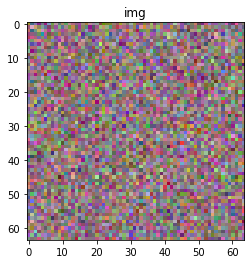

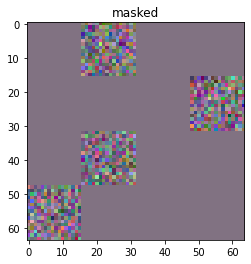

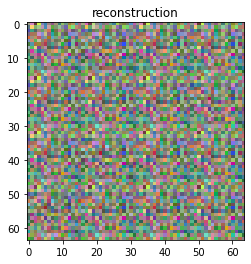

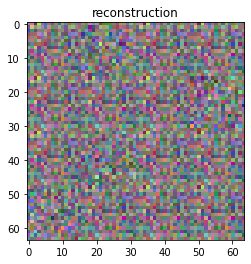

In [62]:
            noise =np.random.randn(batch_size,64,64,3)
            imagenet_mean  = np.mean(noise,(0,1))
            imagenet_std = np.std(noise,(0,1))
#             view1 = spectral.imshow(data=noise, title="img")
            noise = noise - imagenet_mean
            noise = noise / imagenet_std

#             plt.rcParams['figure.figsize'] = [5, 5]
#             # show_image(torch.tensor(img))
#             view1 = spectral.imshow(data=X, title="img")
            torch.manual_seed(2)
            print('MAE with pixel reconstruction:')
#             run_one_image(, model_mae)

#             noise.resize_(batch_size, nz, 1, 1)
#             noise.normal_(0, 1)
#             noise_ = np.random.normal(0, 1, (batch_size, nz, 1, 1))

#             noise.resize_(batch_size, nz, 1, 1).copy_(torch.from_numpy(noise_))


            #label = np.random.randint(0, nb_label, batch_size)
#             label = np.full(batch_size, nb_label)
        

#             f_label.resize_(batch_size).copy_(torch.from_numpy(label))
            fake = run_one_image(noise, model_mae)
            print(fake.shape)

In [5]:

class netG(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(netG, self).__init__()
        self.ReLU = nn.LeakyReLU(0.2, inplace=True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)
        #self.Drop2 = nn.Dropout2d(p=0.5)
        self.Drop2 = DropBlock2D()

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf)

        self.conv6 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)

    def forward(self, input):
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.Drop2(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        output = self.Tanh(x)
        return output

In [6]:

class netD(nn.Module):
    def __init__(self, ndf, nc, nb_label):
        super(netD, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)

        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ndf)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        #self.Drop2 = nn.Dropout2d(p=0.5)
        self.Drop2 = DropBlock2D()
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 2, 4, 1, 0, bias=False)
        #self.disc_linear = nn.Linear(ndf * 2, 1)
        self.aux_linear = nn.Linear(ndf * 2, nb_label+1)
        self.softmax = nn.LogSoftmax(dim=-1)
        #self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        x = self.Drop2(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.Drop2(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 2)
        c = self.aux_linear(x)
        c = self.softmax(c)
        #s = self.disc_linear(x).squeeze()
        #s = self.sigmoid(s)
        return c



# netG = netG(nz, ngf, nc)

In [7]:
# netG = model_mae

netG = netG(nz, ngf, nc)


if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)

netD = netD(ndf, nc, nb_label)

if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

s_criterion = nn.BCELoss()
c_criterion = nn.NLLLoss()

input = torch.FloatTensor(opt.batchSize, nc, opt.imageSize, opt.imageSize)
noise = torch.FloatTensor(opt.batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(opt.batchSize, nz, 1, 1).normal_(0, 1)
s_label = torch.FloatTensor(opt.batchSize)
c_label = torch.LongTensor(opt.batchSize)
f_label = torch.LongTensor(opt.batchSize)



real_label = 0.8
fake_label = 0.2

if opt.cuda:
    netD.cuda()
    netG.cuda()
    s_criterion.cuda()
    c_criterion.cuda()
    input, s_label = input.cuda(), s_label.cuda()
    c_label = c_label.cuda()
    f_label = f_label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

input = Variable(input)
s_label = Variable(s_label)
c_label = Variable(c_label)
f_label = Variable(f_label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)


optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(0.9, 0.999), weight_decay=0.02)
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(0.9, 0.999), weight_decay=0.005)


decreasing_lr = list(map(int, opt.decreasing_lr.split(',')))
print('decreasing_lr: ' + str(decreasing_lr))


def test(predict, labels):
    correct = 0
    pred = predict.data.max(1)[1]
    correct = pred.eq(labels.data).cpu().sum()
    return correct, len(labels.data)


def kappa(testData, k):
    dataMat = np.mat(testData)
    P0 = 0.0
    for i in range(k):
        P0 += dataMat[i, i] * 1.0
    xsum = np.sum(dataMat, axis=1)
    ysum = np.sum(dataMat, axis=0)
    Pe = float(ysum * xsum) / np.sum(dataMat) ** 2
    P0 = float(P0 / np.sum(dataMat) * 1.0)
    cohens_coefficient = float((P0 - Pe) / (1 - Pe))
    return cohens_coefficient



best_acc = 0

for epoch in range(1, opt.niter + 1):
    netD.train()
    netG.train()
    right = 0
    if epoch in decreasing_lr:
        optimizerD.param_groups[0]['lr'] *= 0.9
        optimizerG.param_groups[0]['lr'] *= 0.9

    for i,datas in enumerate(train_loader):
        for j in range(2):    ## Update D 10 times for every G epoch
            netD.zero_grad()
            img, label = datas
            batch_size = img.size(0)
            input.resize_(img.size()).copy_(img)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size).copy_(label)
            c_output = netD(input)

            #s_errD_real = s_criterion(s_output, s_label)
            c_errD_real = c_criterion(c_output, c_label)
            errD_real =  c_errD_real
            errD_real.backward()
            D_x = c_output.data.mean()

            correct, length = test(c_output, c_label)
            #print('real train finished!')

                # train with fake

#             noise =np.random.randn(batch_size,64,64,3)
#             imagenet_mean  = np.mean(noise,(0,1))
#             imagenet_std = np.std(noise,(0,1))
# #             view1 = spectral.imshow(data=noise, title="img")
#             noise = noise - imagenet_mean
#             noise = noise / imagenet_std

#             plt.rcParams['figure.figsize'] = [5, 5]
#             # show_image(torch.tensor(img))
#             view1 = spectral.imshow(data=X, title="img")
#             torch.manual_seed(2)
           
            noise.normal_(0, 1)
            noise_ = np.random.normal(0, 1, (batch_size, nz, 1, 1))

            noise.resize_(batch_size, nz, 1, 1).copy_(torch.from_numpy(noise_))

            #label = np.random.randint(0, nb_label, batch_size)
            label = np.full(batch_size, nb_label)

            f_label.resize_(batch_size).copy_(torch.from_numpy(label))

            print('noise',noise.shape)
            fake = netG(noise)

#             fake = run_one_image(noise, netG)
            print('fake',fake.shape)
            #s_label.fill_(fake_label)
#             fake = fake.to(torch.float32)
            c_output = netD(fake.detach())
#             c_output = netD(fake)
            print('c_output',c_output.shape)
            #s_errD_fake = s_criterion(s_output, s_label)
            c_errD_fake = c_criterion(c_output, f_label)
            errD_fake = c_errD_fake
            errD_fake.backward()
            D_G_z1 = c_output.data.mean()
            errD = errD_real + errD_fake
            optimizerD.step()
            #print('fake train finished!')
            ###############
            #  Updata G
            ##############


        netG.zero_grad()
        #s_label.data.fill_(real_label)  # fake labels are real for generator cost
        c_output = netD(fake)
        #s_errG = s_criterion(s_output, s_label)
        c_errG = c_criterion(c_output, c_label)
        errG = c_errG
        errG.backward()
        D_G_z2 = c_output.data.mean()
        optimizerG.step()
        right += correct
        #print('begin spout!')

    if epoch % 5 == 0:
         print('[%d/%d][%d/%d]   D(x): %.4f D(G(z)): %.4f / %.4f=%.4f,  Accuracy: %.4f / %.4f = %.4f'
                % (epoch, opt.niter, i, len(train_loader),
                  D_x, D_G_z1, D_G_z2, D_G_z1 / D_G_z2,
                 right, len(train_loader.dataset), 100. * right / len(train_loader.dataset)))

        #torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
        #torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
    if epoch%5==0:
        netD.eval()
        netG.eval()
        test_loss = 0
        right = 0
        all_Label=[]
        all_target=[]
        for data, target in test_loader:
            indx_target = target.clone()
            if opt.cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
            #batch_size = data.size(0)
            #noise.resize_(batch_size, nz, 1, 1)
            #noise.normal_(0, 1)
            #noise_ = np.random.normal(0, 1, (batch_size, nz, 1, 1))
            #noise.resize_(batch_size, nz, 1, 1).copy_(torch.from_numpy(noise_))
           
            #fake=netG(noise)
            #output = netD(data)
            #vutils.save_image(data,'%s/real_samples_i_%03d.png' % (opt.outf,epoch))
            #vutils.save_image(fake,'%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch))
            output = netD(data)

            test_loss += c_criterion(output, target).item()
            pred = output.max(1)[1]  # get the index of the max log-probability
            all_Label.extend(pred)
            all_target.extend(target)
            right += pred.cpu().eq(indx_target).sum()

        test_loss = test_loss / len(test_loader)  # average over number of mini-batch
        acc =float(100. * float(right)) / float(len(test_loader.dataset))
        print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
            test_loss, right, len(test_loader.dataset), acc))
        if acc > best_acc:
            best_acc = acc

        #C = confusion_matrix(target.data.cpu().numpy(), pred.cpu().numpy())
        C = confusion_matrix(all_target, all_Label)
        C = C[:num_class,:num_class]
        np.save('c.npy', C)
        k = kappa(C, np.shape(C)[0])
        AA_ACC = np.diag(C) / np.sum(C, 1)
        AA = np.mean(AA_ACC, 0)
        print('OA= %.5f AA= %.5f k= %.5f' % (acc, AA, k))

netG(
  (ReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Drop2): DropBlock2D()
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
netD(
  (LeakyReLU): LeakyReL